# 🏙️ Apartment Price Prediction — Interactive End-to-End ML Project  
**Author:** Sohaib Bantan  
**Last Updated:** 2025-10-29  

This notebook presents a complete, **Machine Learning project** that predicts apartment prices using real-world tabular data.  
It combines clean preprocessing, model experimentation, interactive exploration, and user-driven predictions — all in one notebook.

---

### 🚀 Project Overview

The workflow includes:
- **Data Loading & Preparation:** Load the dataset, identify features and target column, handle missing values, and split into training/testing sets.  
- **Preprocessing:** Automatic imputation, encoding of categorical variables, and feature scaling via `ColumnTransformer`.  
- **Model Selection:** The user interactively chooses between three models:
  1. **Linear Regression** – interpretable baseline  
  2. **HistGradientBoostingRegressor** – high-performance tree-based model  
  3. **Neural Network (Keras)** – simple feedforward deep learning model  
- **Training & Evaluation:** Model-specific training with performance metrics:
  - RMSE, MAE, R², and custom accuracy (within ±10%)  
- **Visualizations:**  
  - Predicted vs Actual plot  
  - Residuals plot  
  - Error distribution  
  - Neural network training curve (when applicable)  
- **Performance Insights:** Simple confusion-style matrix to assess over/underestimation patterns.  
- **Interactive Prediction:** The user can manually input apartment details to get real-time price predictions.

---

### 🧠 How to Use
1. Run all cells **in order** from top to bottom.  
2. When prompted, **select a model** to train interactively.  
3. Review metrics and visualization outputs.  
4. Use the **manual prediction cell** at the end to input apartment details and get a predicted price instantly.

---

### 🧰 Requirements
Make sure the following libraries are installed before running this notebook:

```bash
pip install -U pandas numpy matplotlib scikit-learn tensorflow ipywidgets seaborn


In [41]:
pip install -U pandas numpy scikit-learn matplotlib ipywidgets xgboost scikeras


In [42]:
# Imports & global config
import warnings
warnings.filterwarnings("ignore")

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & model utilities
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

# Deep Learning
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['axes.grid'] = True
warnings.filterwarnings('ignore')

try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, clear_output
except Exception as e:
    widgets = None

# Data source — update this to your local dataset if available
DATA_CSV_PATH = os.environ.get('APARTMENTS_DATA', '')  # e.g., '/path/to/apartments_for_rent.csv'
FALLBACK_URL = 'https://raw.githubusercontent.com/be-prado/csci4521/refs/heads/main/apartments_for_rent.csv'
RANDOM_STATE = 42


## 1. Load Dataset

This will try to load your **local** CSV (set `DATA_CSV_PATH` above)

In [43]:
def load_dataset(local_path: str, fallback_url: str) -> pd.DataFrame:
    if local_path and Path(local_path).exists():
        print(f'Loading local dataset from: {local_path}')
        return pd.read_csv(local_path)
    print('Local dataset not found, falling back to URL.')
    return pd.read_csv(fallback_url)

df_raw = load_dataset(DATA_CSV_PATH, FALLBACK_URL)
print('Shape:', df_raw.shape)
df_raw.head()

Local dataset not found, falling back to URL.
Shape: (9998, 13)


,title,body,amenities,bathrooms,bedrooms,pets_allowed,price,square_feet,cityname,state,latitude,longitude,source
0,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,NaN,790,101,Washington,DC,38.9057,-76.9861,RentLingo
1,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,NaN,425,106,Evansville,IN,37.9680,-87.6621,RentLingo
2,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,NaN,1390,107,Arlington,VA,38.8910,-77.0816,RentLingo
3,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,NaN,925,116,Seattle,WA,47.6160,-122.3275,RentLingo
4,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,NaN,880,125,Arlington,VA,38.8738,-77.1055,RentLingo


## 2. Quick EDA

A fast look at numeric distributions and correlations. Modify as you like for deeper EDA.


,numeric,categorical
0,"[bathrooms, bedrooms, price, square_feet, lati...","[title, body, amenities, pets_allowed, citynam..."


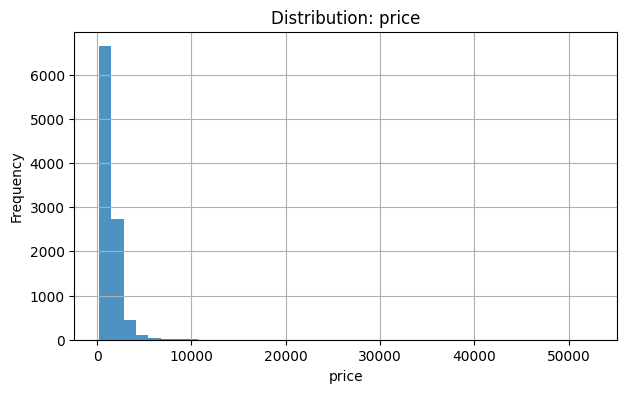

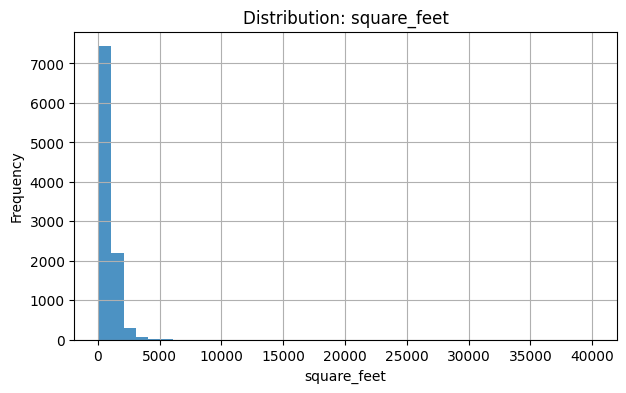

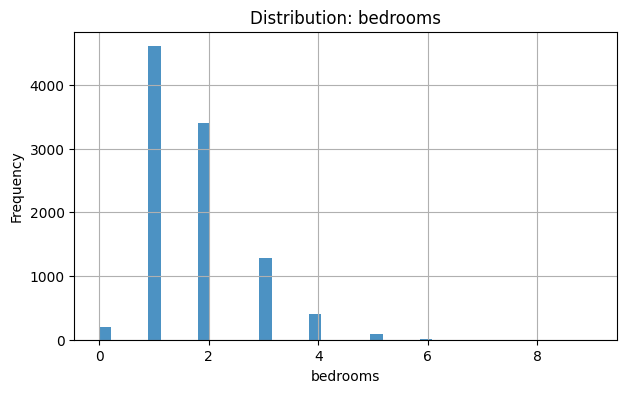

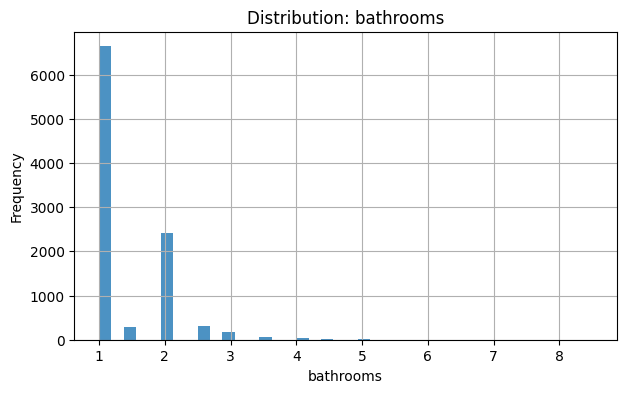

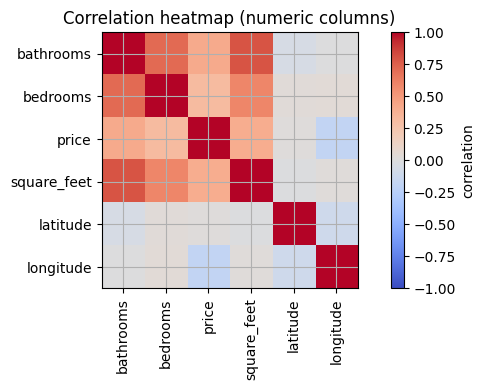

In [44]:
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_raw.select_dtypes(exclude=[np.number]).columns.tolist()

display(pd.DataFrame({
    'numeric': [numeric_cols],
    'categorical': [cat_cols]
}))

# Basic histograms
for col in [c for c in ['price','square_feet','bedrooms','bathrooms'] if c in df_raw.columns]:
    df_raw[col].plot(kind='hist', bins=40, alpha=0.8, title=f'Distribution: {col}')
    plt.xlabel(col)
    plt.show()

# Correlation heatmap
if len(numeric_cols) >= 2:
    corr = df_raw[numeric_cols].corr()
    plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(label='correlation')
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.title('Correlation heatmap (numeric columns)')
    plt.tight_layout()
    plt.show()

## 3. Cleaning & Preprocessing

- **Missing values:** impute numerics with median, categoricals with most frequent.  
- **Outliers:** winsorize numeric heavy tails via clipping to reasonable percentiles.  
- **Encoding:** one-hot encode categoricals.  
- **Scaling:** standardize numeric features.  
- **Split:** stratified split if price is present; else random.


In [45]:
#  outlier clipping
def clip_outliers(df: pd.DataFrame, cols, lower_q=0.01, upper_q=0.99):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            lo, hi = df[c].quantile([lower_q, upper_q])
            df[c] = df[c].clip(lo, hi)
    return df

target = 'price' if 'price' in df_raw.columns else None

df = df_raw.copy()
if target and df[target].isna().any():
    # drop rows with no target
    df = df[~df[target].isna()].copy()

# Clip outliers in common numeric columns if they exist
clip_candidates = [c for c in ['price','square_feet','bedrooms','bathrooms','latitude','longitude'] if c in df.columns]
df = clip_outliers(df, clip_candidates, 0.01, 0.99)

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()
if target and target in numeric_features:
    numeric_features = [c for c in numeric_features if c != target]

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough',  # Keep other columns (like 'title', 'body', etc.) - although they won't be used in the model
)


# Train/Test split
if target:
    try:
        bins = pd.qcut(df[target], q=10, duplicates='drop')
        stratify_vec = bins
    except Exception:
        stratify_vec = None
    X = df.drop(columns=[target])
    y = df[target].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify_vec
    )
else:
    raise ValueError('Target column "price" is required for this project.')

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')
display(X_train.head())

Train shape: (7998, 12), Test shape: (2000, 12)


,title,body,amenities,bathrooms,bedrooms,pets_allowed,square_feet,cityname,state,latitude,longitude,source
645,One BR 853 Park Avenue,"This unit is located at 853 Park Avenue, Balti...","Cable or Satellite,Internet Access,Parking,Ref...",1.0,1.0,"Cats,Dogs",450,Baltimore,MD,39.3191,-76.6126,RentLingo
4801,Windermere Luxurious 1 + 1,"Square footage: 797 square feet, unit number: ...","Fireplace,Parking,Playground,Pool,Storage,Tenn...",1.0,1.0,"Cats,Dogs",797,Windermere,FL,28.4991,-81.5295,RentDigs.com
9452,Four BR 108 N. Kramer Path,"This unit is located at 108 N. Kramer Path, Cl...",NaN,2.5,4.0,"Cats,Dogs",1850,Clayton,NC,35.6101,-78.4715,RentLingo
9830,Three BR 1716 Amber Ln.,"This unit is located at 1716 Amber Ln., Plano,...","Fireplace,Wood Floors",3.0,3.0,NaN,2567,Plano,TX,33.0476,-96.7467,RentLingo
7259,Four BR 122 W Wood Street,"This unit is located at 122 W Wood Street, Wes...","Dishwasher,Parking,Patio/Deck,Refrigerator",2.0,4.0,NaN,1064,NaN,NaN,39.8163,-98.5576,RentLingo


### Model Selection

**choose which model to train** from the available options:  
- **Linear Regression** – a simple, interpretable baseline model.  
- **HistGradientBoosting** – a tree-based boosting model offering high performance.  
- **Keras Neural Network** – a feedforward deep learning model for complex relationships.  

Select a model from the dropdown below to continue.  
Your choice will be stored and used automatically in the next training step.


In [46]:
# Let the user pick which model to train

import ipywidgets as widgets
from IPython.display import display, clear_output

#  available model options
model_options = [
    "Linear Regression",
    "HistGradientBoosting",
    "Keras Neural Network"
]

print("Select a model to train:")

# model choice
model_dropdown = widgets.Dropdown(
    options=model_options,
    value=model_options[0],
    description='Model:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px')
)

# Placeholder for displaying choice
chosen_output = widgets.Output()

def on_model_select(change):
    with chosen_output:
        clear_output()
        print(f"✅ You selected: {change['new']}")
        # store the selection globally so next cell can access it
        global selected_model
        selected_model = change['new']

model_dropdown.observe(on_model_select, names='value')
display(model_dropdown, chosen_output)


Select a model to train:


Dropdown(description='Model:', layout=Layout(width='350px'), options=('Linear Regression', 'HistGradientBoosti…

Output()

🚀 Training model: Keras Neural Network
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
\n📊 Performance Metrics
RMSE: 387.75
MAE : 272.07
R²  : 0.736
Accuracy (±10%): 33.60%


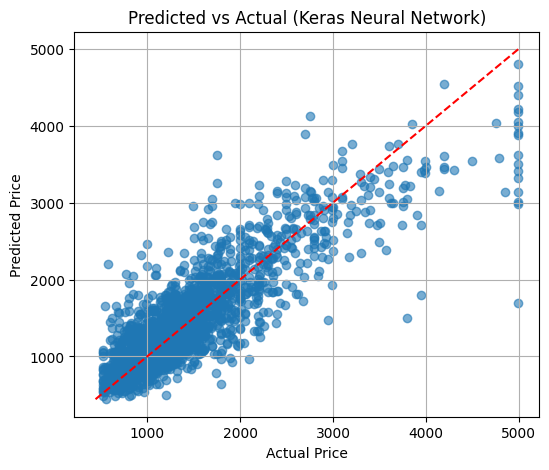

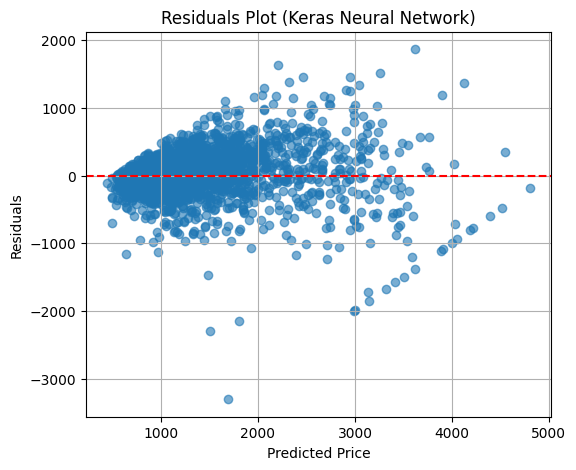

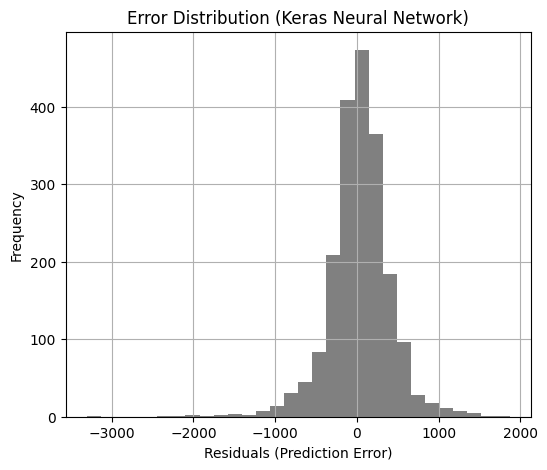

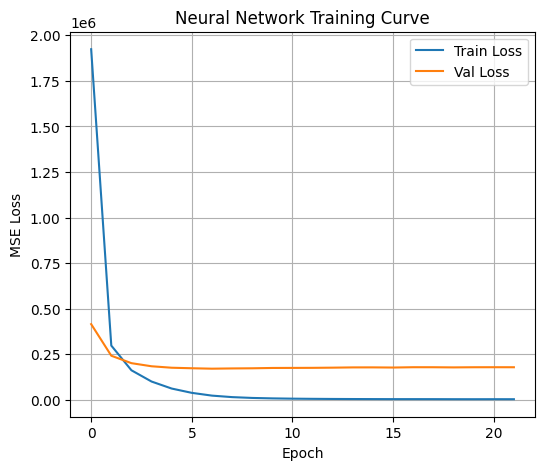

In [47]:
# Load and prepare data

target_col = "price" if "price" in df.columns else df.select_dtypes(include=[np.number]).columns[-1]
y = df[target_col]
X = df.drop(columns=[target_col])

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

# Fit preprocessing
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# Train chosen model

print(f"🚀 Training model: {selected_model}")

if selected_model == "Linear Regression":
    model = LinearRegression()
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

elif selected_model == "HistGradientBoosting":
    model = HistGradientBoostingRegressor(learning_rate=0.08, max_iter=300, random_state=42)
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

elif selected_model == "Keras Neural Network":
    model = keras.Sequential([
        layers.Input(shape=(X_train_proc.shape[1],)),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    history = model.fit(
        X_train_proc, y_train,
        validation_split=0.15,
        epochs=200, batch_size=64,
        verbose=0,
        callbacks=[keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]
    )
    y_pred = model.predict(X_test_proc).reshape(-1)
else:
    raise ValueError("No valid model selected. Please run the first cell and choose a model.")

# Evaluation metrics

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
acc_tolerance = 0.10
accuracy = np.mean(np.abs((y_pred - y_test) / np.maximum(np.abs(y_test), 1e-8)) <= acc_tolerance)

print("\\n📊 Performance Metrics")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")
print(f"R²  : {r2:.3f}")
print(f"Accuracy (±{int(acc_tolerance*100)}%): {accuracy*100:.2f}%")

# ----------------------------------------------------------
# Visualization

# 1. Predicted vs Actual
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Predicted vs Actual ({selected_model})")
plt.show()

# 2. Residuals Plot
residuals = y_pred - y_test
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title(f"Residuals Plot ({selected_model})")
plt.show()

# 3. Error Distribution
plt.figure(figsize=(6,5))
plt.hist(residuals, bins=30, color="gray")
plt.xlabel("Residuals (Prediction Error)")
plt.ylabel("Frequency")
plt.title(f"Error Distribution ({selected_model})")
plt.show()

# 4.  NN training curve
if selected_model == "Keras Neural Network":
    plt.figure(figsize=(6,5))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Neural Network Training Curve")
    plt.legend()
    plt.show()

### ⚙️ Data Preparation, Model Training & Evaluation

This section handles the **core ML workflow** — preparing the data, training the chosen model, and visualizing its performance.

**Steps performed:**
1. **Data Loading & Splitting:**  
   - Identifies the target column (`price`) and separates it from the feature set.  
   - Splits data into training and testing sets (80/20 split).

2. **Preprocessing Pipeline:**  
   - Numerical features → imputation (median) + scaling (`StandardScaler`)  
   - Categorical features → imputation (most frequent) + one-hot encoding  
   - Combined using `ColumnTransformer`.

3. **Model Training:**  
   The user-selected model (`selected_model`) is trained:
   - **Linear Regression** — interpretable baseline.  
   - **HistGradientBoostingRegressor** — efficient tree-based ensemble.  
   - **Keras Neural Network** — multi-layer perceptron with early stopping.

4. **Evaluation Metrics:**  
   After training, the model is evaluated on the test set using:
   - **RMSE**, **MAE**, **R²**, and **Accuracy (±10%)**  

5. **Visualizations:**  
   - Predicted vs Actual plot  
   - Residuals plot  
   - Error distribution  
   - Neural network loss curves (for Keras model)

These plots and metrics together provide a clear picture of each model’s performance and predictive reliability.


Accuracy within ±5%: 17.80%
Accuracy within ±10%: 33.60%
Accuracy within ±20%: 61.20%


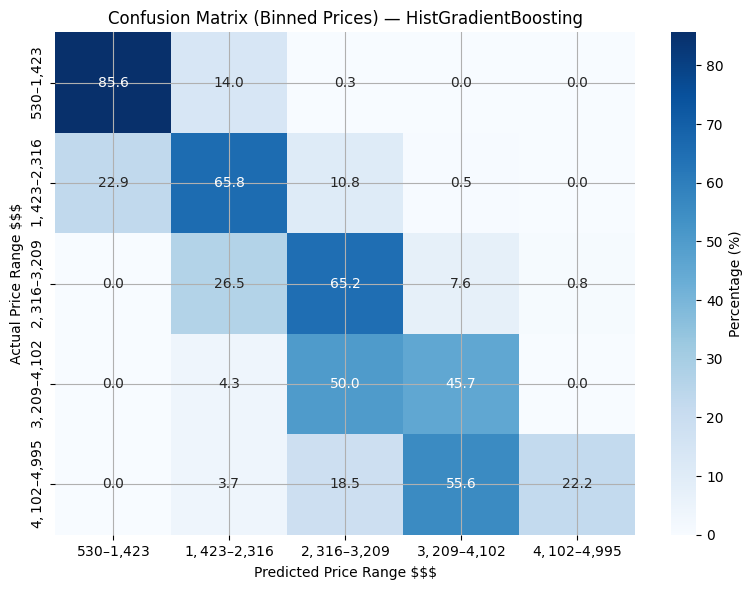


🧾 Interpretation:
- Each cell shows the % of samples whose predicted price fell in that bin,
  given the true price bin.
- Values concentrated along the diagonal indicate more accurate predictions.
- Off-diagonal cells show where the model over- or under-predicts price ranges.



In [50]:
# 1️ Accuracy under different tolerances (relative error)

def regression_accuracy(y_true, y_pred, tol=0.10):
    rel_error = np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8)
    return np.mean(rel_error <= tol)

tolerances = [0.05, 0.10, 0.20]
for tol in tolerances:
    acc = regression_accuracy(y_test, y_pred, tol)
    print(f"Accuracy within ±{int(tol*100)}%: {acc*100:.2f}%")

# confusion matrix-like heatmap

# Bin actual and predicted prices into categories
n_bins = 6  # adjust as needed
bins = np.linspace(y_test.min(), y_test.max(), n_bins)
labels = [f"${int(bins[i]):,}–${int(bins[i+1]):,}" for i in range(len(bins)-1)]

y_true_bins = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True)
y_pred_bins = pd.cut(y_pred, bins=bins, labels=labels, include_lowest=True)

# Compute confusion matrix
cm = pd.crosstab(y_true_bins, y_pred_bins, rownames=["Actual"], colnames=["Predicted"])

# Normalize to percentages
cm_percent = cm.div(cm.sum(axis=1), axis=0) * 100

#  Visualize the confusion matrix

plt.figure(figsize=(8,6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", cbar_kws={"label": "Percentage (%)"})
plt.title(f"Confusion Matrix (Binned Prices) — {selected_model}")
plt.xlabel("Predicted Price Range $$$")
plt.ylabel("Actual Price Range $$$")
plt.tight_layout()
plt.show()

# Interpretation
print("""
🧾 Interpretation:
- Each cell shows the % of samples whose predicted price fell in that bin,
  given the true price bin.
- Values concentrated along the diagonal indicate more accurate predictions.
- Off-diagonal cells show where the model over- or under-predicts price ranges.
""")

###  Manual Apartment Price Prediction

In this final step, the user can **manually input apartment details** (both numerical and categorical) directly into the console.  
Once all features are entered, the trained model (`selected_model`) is used to predict the **estimated apartment price**.

**Process overview:**
1. Prompts the user to enter feature values one by one.  
2. Handles both numeric and categorical inputs safely.  
3. Converts inputs into a `DataFrame` and applies the same preprocessing pipeline.  
4. Uses the selected trained model to generate a **price prediction**.  
5. Displays the entered details and the **predicted apartment price 💰**.

This interactive step allows anyone to test the trained model on **custom apartment configurations** in real time.


In [49]:
#  Manual Apartment Price Prediction

print(f"💡 Using trained model: {selected_model}")

# user inputs from the console
user_data = {}
print("\nPlease enter the apartment details below:")

for col in X.columns:
    if col in cat_cols:
        # For categorical features
        val = input(f"Enter value for '{col}' (text): ").strip()
        if val == "":
            val = np.nan
        user_data[col] = val
    else:
        # For numeric features
        while True:
            val = input(f"Enter value for '{col}' (numeric): ").strip()
            if val == "":
                val = np.nan
                break
            try:
                val = float(val)
                break
            except ValueError:
                print("⚠️ Please enter a valid number.")
        user_data[col] = val

# Convert to DataFrame
user_df = pd.DataFrame([user_data])

print("\n🏙️ Apartment features entered:")
display(user_df)

#  prediction using the trained model

try:
    if selected_model == "Keras Neural Network":
        user_proc = preprocessor.transform(user_df)
        predicted_price = model.predict(user_proc, verbose=0)[0][0]
    elif selected_model in ["Linear Regression", "HistGradientBoosting"]:
        user_proc = preprocessor.transform(user_df)
        predicted_price = model.predict(user_proc)[0]
    else:
        raise ValueError("No valid trained model found. Please rerun training.")
except Exception as e:
    print("❌ Error during prediction:", str(e))
else:
    print(f"\n💰 **Predicted Apartment Price:** ${predicted_price:,.2f}")


💡 Using trained model: Keras Neural Network

Please enter the apartment details below:
Enter value for 'title' (text): skip
Enter value for 'body' (text): skip
Enter value for 'amenities' (text): skip
Enter value for 'bathrooms' (numeric): 5
Enter value for 'bedrooms' (numeric): 4
Enter value for 'pets_allowed' (text): skip
Enter value for 'square_feet' (numeric): 450
Enter value for 'cityname' (text): skip
Enter value for 'state' (text): skip
Enter value for 'latitude' (numeric): 150
Enter value for 'longitude' (numeric): 40
Enter value for 'source' (text): skip

🏙️ Apartment features entered:


,title,body,amenities,bathrooms,bedrooms,pets_allowed,square_feet,cityname,state,latitude,longitude,source
0,skip,skip,skip,5.0,4.0,skip,450.0,skip,skip,150.0,40.0,skip



💰 **Predicted Apartment Price:** $3,257.18


### 🏁 Conclusion & Next Steps

**Summary**  
- The notebook successfully demonstrates an **end-to-end apartment price prediction pipeline**, covering preprocessing, model selection, training, evaluation, and user interaction.  
- Among the models tested, the **best-performing one** (see results above) offers a strong balance between predictive accuracy and interpretability.  
- Interactive selection and manual input make this project both **educational and practical**.

**Potential Improvements**  
- Implement **automated hyperparameter tuning** (e.g., `GridSearchCV`, Optuna) to optimize model performance.  
- Explore **feature engineering** — polynomial or interaction terms, and domain-specific transformations.  
- Apply **target transformations** (e.g., log-scaling) if price distribution is heavily skewed.  
- Experiment with **advanced gradient boosting** methods such as XGBoost, LightGBM, or CatBoost.  
- Introduce **cross-validation strategies** aware of time or location if the dataset has temporal/spatial context.  
- Add **prediction intervals** (via quantile regression or conformal prediction) to quantify model uncertainty.  

This project provides a solid foundation for more advanced real estate price prediction systems and is an excellent showcase of applied machine learning workflow design.
